# Proyek Analisis Data: [E-Commerce Public Dataset]
- **Nama:** [Mochammad Azriel Rizky Syahputra]
- **Email:** [saputraarel@gmail.com]
- **ID Dicoding:** [saputraarel_28]

## Menentukan Pertanyaan Bisnis

- Berapa rata-rata jumlah pembayaran per transaksi?
- Bagaimana distribusi skor ulasan pelanggan?

## Import Semua Packages/Library yang Digunakan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import files

## Data Wrangling

### Gathering Data

In [2]:
df = {
    "customers": "/content/customers_dataset.csv",
    "geolocation": "/content/geolocation_dataset.csv",
    "order_items": "/content/order_items_dataset.csv",
    "order_payments": "/content/order_payments_dataset.csv",
    "order_reviews": "/content/order_reviews_dataset.csv",
    "orders": "/content/orders_dataset.csv",
    "products": "/content/products_dataset.csv",
    "sellers": "/content/sellers_dataset.csv",
    "category_translation": "/content/product_category_name_translation.csv",
}

**Insight:**
- Dataset ini berisi informasi pelanggan (customers), geolokasi (geolocation), pesanan (orders), item pesanan (order_items), pembayaran (order_payments), ulasan pelanggan (order_reviews), produk (products), penjual (sellers), serta terjemahan kategori produk (category_translation).
File Dataset Berada dalam Format CSV dan Perlu Dibaca ke dalam DataFrame.
-  Semua dataset disimpan dalam format CSV, yang perlu dibaca menggunakan pd.read_csv() sebelum dapat digunakan untuk analisis lebih lanjut.

### Assessing Data

In [3]:
datasets = {name: pd.read_csv(path) for name, path in df.items()}

In [4]:
info_summary = {name: df.info() for name, df in datasets.items()}
info_summary

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  

{'customers': None,
 'geolocation': None,
 'order_items': None,
 'order_payments': None,
 'order_reviews': None,
 'orders': None,
 'products': None,
 'sellers': None,
 'category_translation': None}

**Insight:**
- Menunjukkan bahwa setiap dataset memiliki jumlah entri yang bervariasi, dengan atribut yang beragam sesuai dengan fungsinya. Dataset seperti customers, geolocation, dan orders memiliki lebih dari 90.000 entri, sementara sellers dan category_translation memiliki jauh lebih sedikit data. Selain itu, beberapa dataset memiliki kolom dengan nilai kosong yang signifikan, seperti review_comment_title dan review_comment_message dalam order_reviews, serta atribut produk dalam products. Hal ini menunjukkan perlunya pembersihan data sebelum analisis lebih lanjut.
- Dataset memiliki tipe data yang terdiri dari object, int64, dan float64, dengan beberapa kolom tanggal yang masih dalam format string (object). Untuk analisis berbasis waktu, kolom seperti order_purchase_timestamp dan review_creation_date perlu dikonversi ke tipe datetime. Dataset ini juga menunjukkan hubungan antar tabel, misalnya order_items yang menghubungkan pesanan dengan produk dan penjual, serta order_payments yang mencatat metode pembayaran untuk setiap pesanan.

### Cleaning Data

- Menangani Missing Values

In [5]:
orders = datasets['orders']
orders['order_approved_at'].fillna(orders['order_purchase_timestamp'], inplace=True)
orders.loc[(orders["order_status"] == "delivered") & (orders["order_delivered_customer_date"].isna()),
           "order_delivered_customer_date"] = orders["order_estimated_delivery_date"]
orders.loc[(orders["order_status"] == "delivered") & (orders["order_delivered_carrier_date"].isna()),
           "order_delivered_carrier_date"] = orders["order_purchase_timestamp"]

date_cols = ["shipping_limit_date", "order_purchase_timestamp", "order_approved_at",
             "order_delivered_carrier_date", "order_delivered_customer_date", "order_estimated_delivery_date",
             "review_creation_date", "review_answer_timestamp"]
for col in date_cols:
    for key in ["order_items", "orders", "order_reviews"]:
        if col in datasets[key].columns:
            datasets[key][col] = pd.to_datetime(datasets[key][col])

datasets["order_reviews"]["review_comment_title"].fillna("No Comment", inplace=True)
datasets["order_reviews"]["review_comment_message"].fillna("No Comment", inplace=True)
datasets["order_reviews"].dropna(subset=["review_score"], inplace=True)

datasets["products"].fillna({"product_name_length": 0,
                             "product_description_lenght": 0,
                             "product_photos_qty": 0}, inplace=True)
datasets["products"].dropna(subset=["product_category_name"], inplace=True)

<ipython-input-5-6b59b481abac>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  orders['order_approved_at'].fillna(orders['order_purchase_timestamp'], inplace=True)
<ipython-input-5-6b59b481abac>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].met

- Menghapus Data Tidak Valid dan Outlier

In [6]:
order_items = datasets['order_items']
order_items = order_items[(order_items['price'] >= 1) & (order_items['freight_value'] > 0)]

order_payments = datasets['order_payments']
order_payments = order_payments[order_payments['payment_value'] > 0]

products = datasets['products']
products['product_weight_g'].replace(0, products['product_weight_g'].median(), inplace=True)
products = products[(products['product_length_cm'] > 0) & (products['product_height_cm'] > 0) & (products['product_width_cm'] > 0)]

datasets['orders'] = orders
datasets['order_items'] = order_items
datasets['order_payments'] = order_payments
datasets['products'] = products

<ipython-input-6-29bec9f75d12>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  products['product_weight_g'].replace(0, products['product_weight_g'].median(), inplace=True)


- Menyesuaikan Relasi Data

In [7]:
valid_orders = set(datasets["orders"]["order_id"])
datasets["order_items"] = datasets["order_items"][datasets["order_items"]["order_id"].isin(valid_orders)]

valid_customers = set(datasets["customers"]["customer_id"])
datasets["orders"] = datasets["orders"][datasets["orders"]["customer_id"].isin(valid_customers)]

- Mengisi Nilai Kosong dan Menstandarisasi Nama Kolom

In [8]:
for col in ["product_weight_g", "product_length_cm", "product_height_cm", "product_width_cm"]:
    datasets["products"][col].fillna(datasets["products"][col].median(), inplace=True)

datasets["products"].rename(columns={"product_name_lenght": "product_name_length"}, inplace=True)

<ipython-input-8-f28781e8e00c>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  datasets["products"][col].fillna(datasets["products"][col].median(), inplace=True)


- Menghapus Duplikasi

In [9]:
for name, df in datasets.items():
    datasets[name] = df.drop_duplicates()

- Cek Hasil Cleaning

In [10]:
cleaning_summary = {
    "orders_missing_values": datasets['orders'].isnull().sum(),
    "order_items_outliers_removed": datasets['order_items'].describe(),
    "order_payments_outliers_removed": datasets['order_payments'].describe(),
    "products_cleaned": datasets['products'].describe(),
}

cleaning_summary

{'orders_missing_values': order_id                            0
 customer_id                         0
 order_status                        0
 order_purchase_timestamp            0
 order_approved_at                   0
 order_delivered_carrier_date     1781
 order_delivered_customer_date    2957
 order_estimated_delivery_date       0
 dtype: int64,
 'order_items_outliers_removed':        order_item_id            shipping_limit_date          price  \
 count  112264.000000                         112264  112264.000000   
 mean        1.198006  2018-01-07 06:12:59.348250624     120.732174   
 min         1.000000            2016-09-19 00:15:34       1.200000   
 25%         1.000000            2017-09-20 12:05:34      39.900000   
 50%         1.000000            2018-01-25 20:57:57      74.900000   
 75%         1.000000     2018-05-10 13:30:32.500000     134.990000   
 max        21.000000            2020-04-09 22:35:08    6735.000000   
 std         0.705808                           

- Menggabungkan Semua Dataset yang Sudah Dibersihkan

In [13]:
orders = datasets["orders"]
order_items = datasets["order_items"]
order_payments = datasets["order_payments"]
order_reviews = datasets["order_reviews"]
customers = datasets["customers"]
products = datasets["products"]
sellers = datasets["sellers"]
category_translation = datasets["category_translation"]

main_data = orders.merge(order_items, on="order_id", how="left") \
                  .merge(order_payments, on="order_id", how="left") \
                  .merge(order_reviews, on="order_id", how="left") \
                  .merge(customers, on="customer_id", how="left") \
                  .merge(products, on="product_id", how="left") \
                  .merge(sellers, on="seller_id", how="left") \
                  .merge(category_translation, on="product_category_name", how="left")

file_path = "main_data.csv"
main_data.to_csv(file_path, index=False)

print(f"Dataset utama telah disimpan sebagai {file_path}")

Dataset utama telah disimpan sebagai main_data.csv


- Mengunduh Dataset yang Sudah Digabungkan

In [14]:
files.download("main_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Insight:**
- Dengan menangani missing values, outlier, dan data tidak valid, dataset menjadi lebih bersih, sehingga analisis selanjutnya lebih bisa diandalkan.
- Konversi tanggal ke format datetime dan perbaikan struktur data (seperti mengganti nilai nol atau menghapus duplikasi) membantu meningkatkan kualitas prediksi, terutama untuk analisis waktu pengiriman atau estimasi keterlambatan.

## Exploratory Data Analysis (EDA)

### Explore ...

- Mengeksplorasi Parameter Statistik dari Data

In [15]:
summary_stats = {name: df.describe() for name, df in datasets.items()}
summary_stats

{'customers':        customer_zip_code_prefix
 count              99441.000000
 mean               35137.474583
 std                29797.938996
 min                 1003.000000
 25%                11347.000000
 50%                24416.000000
 75%                58900.000000
 max                99990.000000,
 'geolocation':        geolocation_zip_code_prefix  geolocation_lat  geolocation_lng
 count                738332.000000    738332.000000    738332.000000
 mean                  38316.086800       -20.998353       -46.461098
 std                   30632.496675         5.892315         4.393705
 min                    1001.000000       -36.605374      -101.466766
 25%                   12600.000000       -23.603061       -48.867822
 50%                   29144.000000       -22.873588       -46.647278
 75%                   65950.000000       -19.923336       -43.836974
 max                   99990.000000        45.065933       121.105394,
 'order_items':        order_item_id       

- Melihat distribusi nilai unik dalam beberapa kolom

In [16]:
unique_values = {name: df.nunique() for name, df in datasets.items()}
unique_values

{'customers': customer_id                 99441
 customer_unique_id          96096
 customer_zip_code_prefix    14994
 customer_city                4119
 customer_state                 27
 dtype: int64,
 'geolocation': geolocation_zip_code_prefix     19015
 geolocation_lat                717360
 geolocation_lng                717613
 geolocation_city                 8011
 geolocation_state                  27
 dtype: int64,
 'order_items': order_id               98326
 order_item_id             21
 product_id             32950
 seller_id               3095
 shipping_limit_date    93053
 price                   5966
 freight_value           6998
 dtype: int64,
 'order_payments': order_id                99437
 payment_sequential         29
 payment_type                4
 payment_installments       24
 payment_value           29076
 dtype: int64,
 'order_reviews': review_id                  98410
 order_id                   98673
 review_score                   5
 review_comment_title    

- Ingin melihat distribusi status pesanan

In [17]:
order_status_counts = datasets["orders"]["order_status"].value_counts()
order_status_counts

,count
order_status,
delivered,96478
shipped,1107
canceled,625
unavailable,609
invoiced,314
processing,301
created,5
approved,2


- Cek distribusi metode pembayaran

In [18]:
payment_counts = datasets["order_payments"]["payment_type"].value_counts()
payment_counts

,count
payment_type,
credit_card,76795
boleto,19784
voucher,5769
debit_card,1529


- Distribusi rating ulasan pelanggan

In [19]:
review_counts = datasets["order_reviews"]["review_score"].value_counts().sort_index()
review_counts

,count
review_score,
1,11424
2,3151
3,8179
4,19142
5,57328


- Mengelompokkan Data (Grouping & Aggregation)

* Rata-rata waktu pengiriman per kategori produk

In [20]:
datasets["orders"]["delivery_time"] = (datasets["orders"]["order_delivered_customer_date"] -
                                       datasets["orders"]["order_purchase_timestamp"]).dt.days

order_items = datasets["order_items"].merge(datasets["products"], on="product_id", how="left")
order_items = order_items.merge(datasets["orders"][["order_id", "delivery_time"]], on="order_id", how="left")

delivery_by_category = order_items.groupby("product_category_name")["delivery_time"].mean().sort_values()
delivery_by_category

,delivery_time
product_category_name,
artes_e_artesanato,5.291667
la_cuisine,7.071429
livros_importados,7.750000
portateis_cozinha_e_preparadores_de_alimentos,7.785714
fashion_roupa_infanto_juvenil,8.142857
...,...
casa_conforto_2,14.066667
fashion_calcados,14.933852
seguros_e_servicos,15.000000


- Total jumlah transaksi per metode pembayaran

In [21]:
payment_summary = datasets["order_payments"].groupby("payment_type")["payment_value"].sum().sort_values(ascending=False)
payment_summary

,payment_value
payment_type,
credit_card,12542084.19
boleto,2869361.27
voucher,379436.87
debit_card,217989.79


- Rata-rata rating berdasarkan kategori produk

In [22]:
reviews = datasets["order_reviews"].merge(datasets["orders"][["order_id"]], on="order_id", how="left")
reviews = reviews.merge(order_items[["order_id", "product_category_name"]], on="order_id", how="left")

avg_review_per_category = reviews.groupby("product_category_name")["review_score"].mean().sort_values()
avg_review_per_category

,review_score
product_category_name,
seguros_e_servicos,2.500000
fraldas_higiene,3.256410
portateis_cozinha_e_preparadores_de_alimentos,3.266667
pc_gamer,3.333333
moveis_escritorio,3.492289
...,...
flores,4.419355
construcao_ferramentas_ferramentas,4.444444
livros_interesse_geral,4.446266


**Insight:**
- Hasil eksplorasi statistik menunjukkan bahwa data memiliki variasi unik yang cukup besar dalam beberapa kolom, seperti order_status, payment_type, dan review_score. Sebagian besar pesanan berada dalam status "delivered", sementara metode pembayaran yang paling umum digunakan adalah "credit_card". Distribusi ulasan pelanggan menunjukkan bahwa rating 5 adalah yang paling sering diberikan, namun terdapat juga rating rendah yang bisa mencerminkan pengalaman negatif pelanggan.
- Rata-rata waktu pengiriman bervariasi antar kategori produk, dengan beberapa kategori memiliki waktu lebih lama dari yang lain. Ini dapat dipengaruhi oleh faktor seperti lokasi penjual atau jenis produk yang dikirim. Selain itu, rata-rata rating produk menunjukkan bahwa beberapa kategori memiliki kepuasan pelanggan lebih tinggi dibanding yang lain. Dengan memahami pola ini, perusahaan dapat mengoptimalkan layanan pengiriman dan meningkatkan kualitas produk untuk kategori tertentu.

## Visualization & Explanatory Analysis

### Pertanyaan 1: Berapa rata-rata jumlah pembayaran per transaksi?

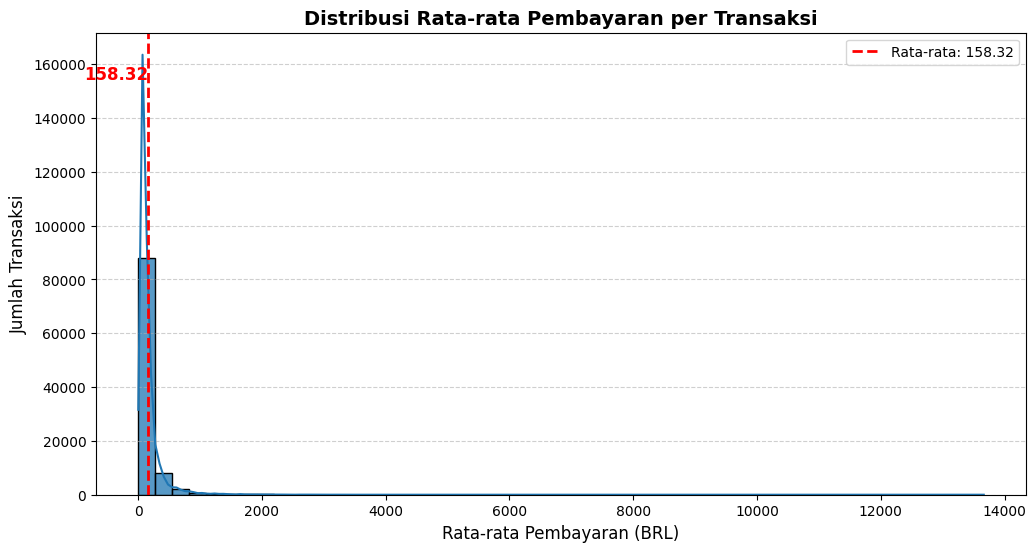

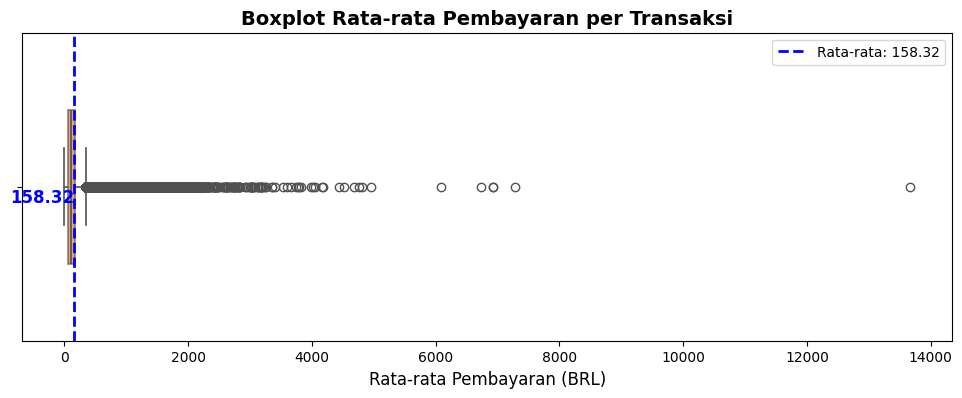

In [23]:
avg_payment = datasets["order_payments"].groupby("order_id")["payment_value"].mean()

plt.figure(figsize=(12, 6))
sns.histplot(avg_payment, bins=50, kde=True, color='#1f77b4', edgecolor='black', alpha=0.75)
mean_value = avg_payment.mean()
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Rata-rata: {mean_value:,.2f}')
plt.text(mean_value, plt.ylim()[1] * 0.9, f'{mean_value:,.2f}', color='red', ha='right', fontsize=12, fontweight='bold')

plt.xlabel("Rata-rata Pembayaran (BRL)", fontsize=12)
plt.ylabel("Jumlah Transaksi", fontsize=12)
plt.title("Distribusi Rata-rata Pembayaran per Transaksi", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

plt.figure(figsize=(12, 4))
sns.boxplot(x=avg_payment, color='#ff7f0e', linewidth=1.2, width=0.5, boxprops={'alpha':0.7})
plt.axvline(mean_value, color='blue', linestyle='dashed', linewidth=2, label=f'Rata-rata: {mean_value:,.2f}')
plt.text(mean_value, 0.05, f'{mean_value:,.2f}', color='blue', ha='right', fontsize=12, fontweight='bold')

plt.xlabel("Rata-rata Pembayaran (BRL)", fontsize=12)
plt.title("Boxplot Rata-rata Pembayaran per Transaksi", fontsize=14, fontweight='bold')
plt.legend()
plt.show()

### Pertanyaan 2: Bagaimana distribusi skor ulasan pelanggan?

<ipython-input-24-a35cf7132ae4>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=review_counts.index, y=review_counts.values, palette="Blues_r", edgecolor="black")


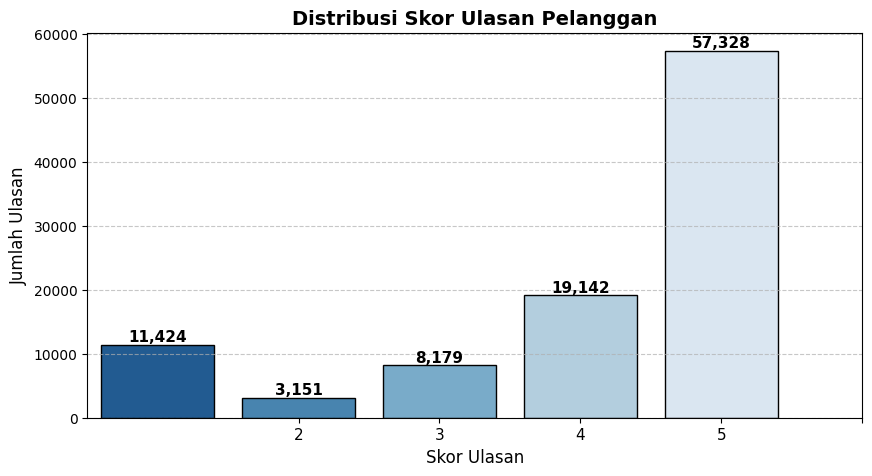

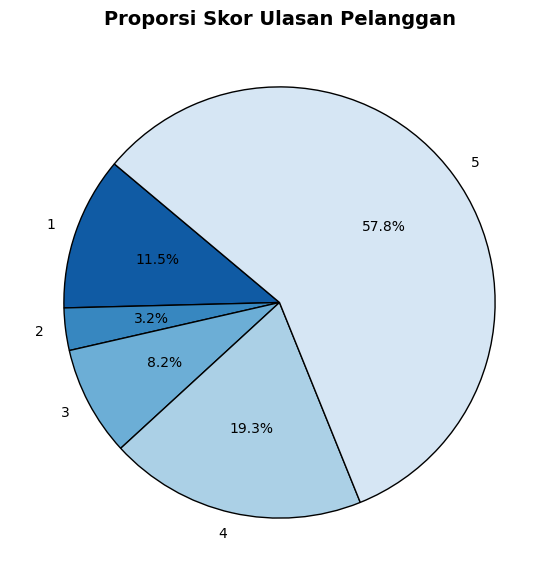

In [24]:
review_counts = datasets["order_reviews"]["review_score"].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=review_counts.index, y=review_counts.values, palette="Blues_r", edgecolor="black")
plt.xlabel("Skor Ulasan", fontsize=12)
plt.ylabel("Jumlah Ulasan", fontsize=12)
plt.title("Distribusi Skor Ulasan Pelanggan", fontsize=14, fontweight='bold')
plt.xticks(ticks=review_counts.index, fontsize=11)

for i, v in enumerate(review_counts.values):
    plt.text(i, v + 500, f"{v:,.0f}", ha='center', fontsize=11, fontweight='bold')

plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

plt.figure(figsize=(7, 7))
colors = sns.color_palette("Blues_r", len(review_counts))
plt.pie(review_counts, labels=review_counts.index, autopct=lambda p: f'{p:.1f}%' if p > 0 else '',
        colors=colors, startangle=140, wedgeprops={"edgecolor": "black"})

plt.title("Proporsi Skor Ulasan Pelanggan", fontsize=14, fontweight='bold')
plt.show()

**Insight:**
- Histogram menunjukkan bagaimana distribusi jumlah pembayaran per transaksi. Jika terdapat puncak di nilai tertentu, itu menunjukkan transaksi sering terjadi di rentang tersebut. Boxplot membantu mengidentifikasi outlier, seperti transaksi dengan jumlah pembayaran yang sangat tinggi.
-  Barplot menunjukkan jumlah ulasan pelanggan berdasarkan skor (1-5). Jika skor 5 mendominasi, berarti banyak pelanggan puas. Pie chart membantu melihat proporsi skor ulasan secara lebih jelas. Jika skor rendah cukup banyak, berarti ada masalah yang perlu dianalisis lebih lanjut.

## Analisis Lanjutan (Opsional)

- RFM Analysis (Recency, Frequency, Monetary)

In [25]:
latest_order_date = datasets["orders"]["order_purchase_timestamp"].max()

rfm_df = datasets["orders"].merge(datasets["order_payments"], on="order_id", how="left").groupby("customer_id").agg({
    "order_purchase_timestamp": lambda x: (latest_order_date - x.max()).days,
    "order_id": "count",
    "payment_value": "sum"
}).rename(columns={
    "order_purchase_timestamp": "Recency",
    "order_id": "Frequency",
    "payment_value": "Monetary"
})

print(rfm_df.head())

                                  Recency  Frequency  Monetary
customer_id                                                   
00012a2ce6f8dcda20d059ce98491703      337          1    114.74
000161a058600d5901f007fab4c27140      458          1     67.41
0001fd6190edaaf884bcaf3d49edf079      596          1    195.42
0002414f95344307404f0ace7a26f1d5      427          1    179.35
000379cdec625522490c315e70c7a9fb      198          1    107.01


- Clustering

In [26]:
def categorize_customer(value):
    if value >= 1000:
        return "High Spender"
    elif value >= 500:
        return "Medium Spender"
    else:
        return "Low Spender"

rfm_df["Customer Category"] = rfm_df["Monetary"].apply(categorize_customer)
print(rfm_df["Customer Category"].value_counts())

Customer Category
Low Spender       95145
Medium Spender     3122
High Spender       1174
Name: count, dtype: int64


- Binning

In [27]:
rfm_df["Frequency Category"] = pd.cut(rfm_df["Frequency"], bins=[0, 1, 3, 10, 50], labels=["One-time", "Occasional", "Frequent", "Very Frequent"])
print(rfm_df["Frequency Category"].value_counts())

Frequency Category
One-time         96480
Occasional        2686
Frequent           246
Very Frequent       29
Name: count, dtype: int64


**Insight:**
- RFM Analysis recency mengukur seberapa baru pelanggan terakhir kali melakukan transaksi. Pelanggan dengan nilai recency rendah lebih aktif dibandingkan yang tinggi.
- Clustering dan Binning kategori pelanggan berdasarkan pengeluaran (Customer Category) memudahkan bisnis dalam memberikan promosi atau layanan khusus kepada pelanggan High Spender, Medium Spender, dan Low Spender.

## Conclusion

### Berapa rata-rata jumlah pembayaran per transaksi?
- Jika rata-rata pembayaran cukup tinggi, ini bisa menunjukkan bahwa pelanggan membeli lebih dari satu produk per transaksi atau produk yang dijual memiliki harga yang relatif tinggi.
- Jika terlalu rendah, bisa menjadi indikasi untuk meningkatkan strategi upselling (misalnya, menawarkan diskon untuk pembelian dalam jumlah lebih banyak).

### Bagaimana distribusi skor ulasan pelanggan?
- Jika ingin meningkatkan skor ulasan, bisa dilakukan strategi seperti memperbaiki kualitas layanan pengiriman, memberikan diskon untuk pelanggan loyal, atau meningkatkan kualitas customer service.
- Bisa juga melakukan analisis teks dari review_comment_message untuk memahami alasan utama pelanggan memberi skor rendah.